In [83]:
import time
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score #交叉检验
from sklearn.feature_selection import SelectPercentile, f_classif #特征选择方法
from sklearn.ensemble import AdaBoostClassifier #集成算法
from sklearn.pipeline import Pipeline #Pipeline库
from sklearn.metrics import accuracy_score #准确率指标
import warnings
warnings.filterwarnings('ignore')

### 1、数据应用

In [44]:
# 加载数据
data = pd.read_excel('order.xlsx', sheetname=0)

In [45]:
data.head(4)

,age,total_pageviews,edu,edu_ages,user_level,industry,value_level,act_level,sex,blue_money,red_money,work_hours,region,response
0,39.0,77516.0,1.0,13.0,1.0,1.0,1,1.0,1.0,2174,0.0,40,1.0,0
1,50.0,83311.0,1.0,13.0,2.0,2.0,2,1.0,1.0,0,0.0,13,1.0,0
2,38.0,215646.0,2.0,9.0,3.0,3.0,1,1.0,1.0,0,0.0,40,1.0,0
3,53.0,234721.0,2.0,7.0,2.0,3.0,2,2.0,1.0,0,0.0,40,1.0,0


In [46]:
# 分割数据X，Y
X = data.drop('response',axis=1)
y = data['response']

### 2、数据审查和预处理

In [47]:
# 基本状态查看
def fprint(s):
    print '{:-^100}'.format(s)

def get_summary(data):
    fprint(' Data Overview ')
    fprint(' Records: {0}|Dimension: {1} '.format(data.shape[0], (data.shape[1] - 1)))
    fprint(' Date Sample ')
    fprint(data.head(3))
    fprint(' Data Desc ')
    fprint(data.describe())
    fprint(' Data Info ')
    print(data.info())
    fprint(' End')

In [48]:
get_summary(data)

------------------------------------------ Data Overview -------------------------------------------
----------------------------------- Records: 39999|Dimension: 13 -----------------------------------
------------------------------------------- Date Sample --------------------------------------------
    age  total_pageviews  edu  edu_ages  user_level  industry  value_level  \
0  39.0          77516.0  1.0      13.0         1.0       1.0            1   
1  50.0          83311.0  1.0      13.0         2.0       2.0            2   
2  38.0         215646.0  2.0       9.0         3.0       3.0            1   

   act_level  sex  blue_money  red_money  work_hours  region  response  
0        1.0  1.0        2174        0.0          40     1.0         0  
1        1.0  1.0           0        0.0          13     1.0         0  
2        1.0  1.0           0        0.0          40     1.0         0  
-------------------------------------------- Data Desc -------------------------------------

In [49]:
# 缺失值检查
# 有缺失的列
data.isnull().any(axis=0)

age                 True
total_pageviews     True
edu                 True
edu_ages            True
user_level          True
industry            True
value_level        False
act_level           True
sex                 True
blue_money         False
red_money           True
work_hours         False
region              True
response           False
dtype: bool

In [50]:
# 有缺失的行记录个数
data.isnull().any(axis=1).sum()

12

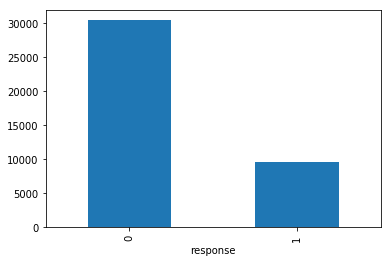

In [51]:
# 类样本均衡均衡审查，选取分类列value_level、user_level等，以目标变量为维度
col = 'value_level'
data[col].groupby(data['response']).count().plot.bar()
# 类样本分布均衡，无需做类样本均衡处理

In [52]:
# 数据备份
data_bak = data.copy()

In [53]:
# 缺失值替换
def na_replace(df):
    na_rules = {
        'age': df['age'].mean(),
        'total_pageviews': df['total_pageviews'].mean(),
        'edu': df['edu'].mean(),
        'edu_ages': df['edu_ages'].median(),
        'user_level': df['user_level'].median(),
        'industry': df['industry'].median(),
        'act_level': df['act_level'].median(),
        'sex': df['sex'].median(),
        'red_money': df['red_money'].mean(),
        'region': df['region'].median(),
    }
    data_tra = df.fillna(na_rules)
    print 'Check NA exists: ',data_tra.isnull().any().sum()
    return data_tra
X_1 = na_replace(X)
X_1.head(3)

Check NA exists:  0


,age,total_pageviews,edu,edu_ages,user_level,industry,value_level,act_level,sex,blue_money,red_money,work_hours,region
0,39.0,77516.0,1.0,13.0,1.0,1.0,1,1.0,1.0,2174,0.0,40,1.0
1,50.0,83311.0,1.0,13.0,2.0,2.0,2,1.0,1.0,0,0.0,13,1.0
2,38.0,215646.0,2.0,9.0,3.0,3.0,1,1.0,1.0,0,0.0,40,1.0


In [56]:
# 数据变量转换
def dtype_con(df):
    val_list = {
        'edu':'int32',
        'edu_ages':'int32',
        'user_level':'int32',
        'industry':'int32',
        'act_level':'int32',
        'sex':'int32',
        'region':'int32',
    }
    for var,val_type in val_list.items():
        df[var] = df[var].astype(val_type)
    return df
X_2 = dtype_con(X_1)
X_2.dtypes

age                float64
total_pageviews    float64
edu                  int32
edu_ages             int32
user_level           int32
industry             int32
value_level          int64
act_level            int32
sex                  int32
blue_money           int64
red_money          float64
work_hours           int64
region               int32
dtype: object

In [59]:
# 将分类和顺序数据转换为标志
def symbol_transfer(df, enc_object=None, train=True):
    """
    Des 将分类和顺序变量转换为二值化的标志变量
    :param df: 数据框
    :param enc_object: sklearn的标志转换对象，训练阶段设置默认值为None；预测阶段使用从训练阶段获得的转换对象
    :param train: 是否为训练阶段
    :return: 转化后的数据框、标志转化对象（train=True）
    """
    convert_cols = ['edu','user_level','industry','value_level','act_level','sex','region']
    no_convert_cols = df.columns.tolist()
    [no_convert_cols.remove(col) for col in convert_cols]
    df_con = df[convert_cols] # 要做标志转化的数据dataframe
    df_org = df[no_convert_cols].values # 不做标志转化的列numpy.ndarray
    if train:
        enc = OneHotEncoder() # 建立标志转化模型对象
        enc.fit(df_con) # 训练模型
        df_con_new = enc.transform(df_con).toarray() # 转换数据并输出数组格式
        new_metrix = np.hstack((df_con_new, df_org)) # 合并数据
        return new_metrix, enc
    else:
        df_con_new = enc_object.transform(df_con).toarray() # 使用训练阶段获得的转换对象转换数据并输出数组
        new_metrix = np.hstack((df_con_new, df_org)) # 合并数据
        return new_metrix
X_new,enc = symbol_transfer(X_2, enc_object=None, train=True)
X_new

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 2.174e+03, 0.000e+00,
        4.000e+01],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.300e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+01],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        4.500e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.200e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+01]])

#### 小插曲 Numpy.hstack/vstack

In [77]:
# h(v)stack(para)
"""
:param para: 需要合并的两个矩阵，格式必须为元组tuple
:return: numpy.ndarray
"""
b = a = np.arange(6).reshape(2,3)
print 'a/b shape:',b.shape
print 'hstack:',np.hstack((a,b)).shape # 左右合并
print 'concatenate(..,axis=1):',np.concatenate((a,b), axis=1).shape # hstack等价于concatenate(..,axis=1)
print 'vstack:',np.vstack((a,b)).shape # 上下合并
print 'concatenate(..,axis=0):',np.concatenate((a,b), axis=0).shape # vstack等价于concatenate(..,axis=0)

a/b shape: (2, 3)
hstack: (2, 6)
concatenate(..,axis=1): (2, 6)
vstack: (4, 3)
concatenate(..,axis=0): (4, 3)


### 3、分类模型训练

In [92]:
# 获得最佳模型参数
def get_best_model(X,y):
    """
    结合交叉检验以得到不同参数下的分类模型结果
    :param X: 输入X(特征变量)
    :param y: 输入y(目标变量)
    :return: 特征选择模型对象
    """
    # 使用f_classif方法选择特征最明显的50%数量的特征
    transform = SelectPercentile(f_classif, percentile=50)
    # 创建Adaboost模型对象
    model_adaboost = AdaBoostClassifier()
    # 建立由特征选择和分类模型构成的管道对象
    # 目的：将特征选择和分类算法合并做交叉检验，简化交叉检验的过程
    model_pipe = Pipeline(steps=[('ANOVA', transform), ('model_adaboost', model_adaboost)])
    # 设置交叉检验次数
    cv = StratifiedKFold(5)
    # 设置交叉检验的指标
    score_methods = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
    # 设置模型参数列表
    n_estimators = [20, 50, 80, 100]
    # 建立空列表存放不同参数得出指标的mead/std
    mean_list, std_list = list(), list()
    for param in n_estimators:
        begin = time.time()
        score_list = list()
        fprint('set param: %s'%param)
        for method in score_methods:
            # 通过管道设置分类模型参数
            model_pipe.set_params(model_adaboost__n_estimators=param)
            # 使用交叉检验计算制定指标得分
            score_tmp = cross_val_score(model_pipe, X, y, scoring=method, cv=cv)
            score_list.append(score_tmp)
        score_matrix = pd.DataFrame(np.array(score_list), index=score_methods)
        score_mean = score_matrix.mean(axis=1).rename('mean')
        score_std = score_matrix.std(axis=1).rename('std')
        score_pd = pd.concat([score_matrix, score_mean, score_std], axis=1)
        mean_list.append(score_mean)
        std_list.append(score_std)
        # DataFrame保留两位小数输出
        print score_pd.round(2)
        fprint('time: %s'%str(time.time() - begin))
    # 建立所有参数交叉检验均值矩阵
    mean_matrix = np.array(mean_list).T
    # 建立所有参数交叉检验标准差矩阵
    std_matrix = np.array(std_list).T
    mean_pd = pd.DataFrame(mean_matrix, index=score_methods, columns=n_estimators)
    std_pd = pd.DataFrame(std_matrix, index=score_methods, columns=n_estimators)
    fprint('Mean values for each parameter')
    print mean_pd
    fprint('Std values for each parameter')
    print std_pd
    return transform
transform = get_best_model(X_new, y)

-------------------------------------------set param: 20--------------------------------------------
              0     1     2     3     4  mean   std
accuracy   0.85  0.85  0.86  0.86  0.86  0.85  0.01
f1         0.66  0.64  0.66  0.66  0.66  0.66  0.01
precision  0.72  0.74  0.76  0.78  0.77  0.75  0.02
recall     0.60  0.57  0.59  0.58  0.57  0.58  0.01
roc_auc    0.91  0.90  0.91  0.91  0.91  0.91  0.00
----------------------------------------time: 11.0082759857-----------------------------------------
-------------------------------------------set param: 50--------------------------------------------
              0     1     2     3     4  mean   std
accuracy   0.86  0.86  0.86  0.87  0.86  0.86  0.00
f1         0.66  0.66  0.67  0.69  0.68  0.67  0.01
precision  0.75  0.76  0.77  0.78  0.77  0.77  0.01
recall     0.59  0.58  0.59  0.62  0.61  0.60  0.02
roc_auc    0.91  0.91  0.91  0.92  0.92  0.91  0.00
----------------------------------------time: 24.7135848999--------------

In [93]:
# 应用特征选择对象
transform.fit(X_new, y)
# 获取具有显著性的特征
X_final = transform.transform(X_new)
# 从上面打印的参数对比获取最佳参数80
final_model = AdaBoostClassifier(n_estimators=80)
# 训练模型
final_model.fit(X_final, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=80, random_state=None)

#### 4、新数据集做预测

In [96]:
new_data_ = pd.read_excel('order.xlsx', sheetname=1)
# 获取目标变量值
final_response = new_data_['final_response']
new_data = new_data_.drop('final_response', axis=1)

In [97]:
# 查看数据基本状态
get_summary(new_data)

------------------------------------------ Data Overview -------------------------------------------
----------------------------------- Records: 8843|Dimension: 12 ------------------------------------
------------------------------------------- Date Sample --------------------------------------------
   age  total_pageviews  edu  edu_ages  user_level  industry  value_level  \
0   61           243019   10         1         2.0       7.0            2   
1   33           215596    4         5         2.0       7.0            2   
2   25            31350    2        10         1.0       5.0            1   

   act_level  sex  blue_money  red_money  work_hours  region  
0          1    1           0          0          40     1.0  
1          5    1           0          0          40     6.0  
2          1    1           0          0          40     1.0  
-------------------------------------------- Data Desc ---------------------------------------------
               age  total_pageviews

In [144]:
# 缺失数据审查
def na_summary(df):
    fprint('columns get NA describe')
    print df.isnull().any(axis=0)
    fprint(pd.DataFrame(df.isnull().any(axis=0), columns=['is_na']).query('is_na==True').index.tolist())
    fprint('NA record {0}'.format(df.isnull().any(axis=1).sum()))
na_summary(new_data)

--------------------------------------columns get NA describe---------------------------------------
age                False
total_pageviews    False
edu                False
edu_ages           False
user_level          True
industry            True
value_level        False
act_level          False
sex                False
blue_money         False
red_money          False
work_hours         False
region              True
dtype: bool
--------------------------------['user_level', 'industry', 'region']--------------------------------
--------------------------------------------NA record 7---------------------------------------------


In [109]:
# 替换缺失值
new_X_1 = na_replace(new_data)
new_X_1.head(3)

Check NA exists:  0


,age,total_pageviews,edu,edu_ages,user_level,industry,value_level,act_level,sex,blue_money,red_money,work_hours,region
0,61,243019,10,1,2.0,7.0,2,1,1,0,0,40,1.0
1,33,215596,4,5,2.0,7.0,2,5,1,0,0,40,6.0
2,25,31350,2,10,1.0,5.0,1,1,1,0,0,40,1.0


In [110]:
# 数据类型转换
new_X_2 = dtype_con(new_X_1)
new_X_2.dtypes

age                int64
total_pageviews    int64
edu                int32
edu_ages           int32
user_level         int32
industry           int32
value_level        int64
act_level          int32
sex                int32
blue_money         int64
red_money          int64
work_hours         int64
region             int32
dtype: object

In [111]:
# 将分类和顺序数据转换为标志变量
new_X_3 = symbol_transfer(new_X_2, enc_object=enc, train=False)

In [112]:
# 对新数据集做特征选择
new_X_final = transform.transform(new_X_3)

In [118]:
# 获取预测标签
pre_labels = pd.DataFrame(final_model.predict(new_X_final), columns=['labels'])
# 获取预测概率
pre_labels_pro = pd.DataFrame(final_model.predict_proba(new_X_final), columns=['pro1','pro2'])
# 合并
pre_pd = pd.concat((new_data, pre_labels, final_response, pre_labels_pro), axis=1)
pre_pd.head(3)

,age,total_pageviews,edu,edu_ages,user_level,industry,value_level,act_level,sex,blue_money,red_money,work_hours,region,labels,final_response,pro1,pro2
0,61,243019,10,1,2.0,7.0,2,1,1,0,0,40,1.0,0,0,0.505057,0.494943
1,33,215596,4,5,2.0,7.0,2,5,1,0,0,40,6.0,0,0,0.508945,0.491055
2,25,31350,2,10,1.0,5.0,1,1,1,0,0,40,1.0,0,0,0.515232,0.484768


In [143]:
# 对比结果，手动计算错误率
fprint(' Error rate: {0} '.format(float(pre_pd.query('labels != final_response').shape[0])/float(pre_pd.shape[0])))
pre_pd.query('labels != final_response').head(3)

------------------------------------ Error rate: 0.137962230012 ------------------------------------


,age,total_pageviews,edu,edu_ages,user_level,industry,value_level,act_level,sex,blue_money,red_money,work_hours,region,labels,final_response,pro1,pro2
15,35,191779,2,10,2.0,7.0,2,1,1,0,0,40,1.0,0,1,0.502991,0.497009
30,36,60269,1,13,2.0,6.0,2,1,1,0,0,40,1.0,0,1,0.500112,0.499888
33,61,95680,2,10,2.0,10.0,2,3,1,0,0,40,1.0,0,1,0.502785,0.497215


In [141]:
# 用accuracy_score得出精准率
fprint(' Accuracy rate: {0} '.format(accuracy_score(final_response, pre_labels)))

---------------------------------- Accuracy rate: 0.862037769988 -----------------------------------
